In [59]:
## import math
import torch
from torch import nn
from d2l import torch as d2l

# self-attention
---
Given a sequence of input tokens
$\mathbf{x}_1, \ldots, \mathbf{x}_n$ where any $\mathbf{x}_i \in \mathbb{R}^d$ ($1 \leq i \leq n$),
its self-attention outputs
a sequence of the same length
$\mathbf{y}_1, \ldots, \mathbf{y}_n$,
where

$$\mathbf{y}_i = f(\mathbf{x}_i, (\mathbf{x}_1, \mathbf{x}_1), \ldots, (\mathbf{x}_n, \mathbf{x}_n)) \in \mathbb{R}^d
$$  
query對不同key, value對做attention pooling, output為y, 其shape與input大小相同

In [60]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5)

/Users/welcome870117/opt/anaconda3/envs/trading/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [61]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))

In [62]:
attention(X, X, X, valid_lens).shape == X.shape

True

# comparing CNN, RNN, self-attention
---
#### 計算複雜度比較:

`self-attention: `   
$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$

1. 計算相似度: $QK^T$, $n*d$&$n*d$ -> $O(n^2d)$  
2. softmax: 對每行softmax, $O(n)$,執行n行 -> $O(n^2)$  
3. 加權和: $n*n$($\alpha(Q,K)$), $n*d(V)$ -> $O(n^2d)$  

`muti-head attention: `  
Given a query $\mathbf{q} \in \mathbb{R}^{d_q}$,
a key $\mathbf{k} \in \mathbb{R}^{d_k}$,
and a value $\mathbf{v} \in \mathbb{R}^{d_v}$,
each attention head $\mathbf{h}_i$  ($i = 1, \ldots, h$)
is computed as
$$\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v},$$

where learnable parameters
$\mathbf W_i^{(q)}\in\mathbb R^{p_q\times d_q}$,
$\mathbf W_i^{(k)}\in\mathbb R^{p_k\times d_k}$
and $\mathbf W_i^{(v)}\in\mathbb R^{p_v\times d_v}$,
and
$f$ is attention pooling,
such as
additive attention and scaled dot-product attention.

1. linear projection: $n*d$ & $d*d/h$ -> $O(nd^2)$(忽略常數)  
(linear projection更細節的操作方法是將input映射到hidden state再透過reshape轉成muti-head的shape)
2. attention: $n*d/h$ & $d/h*n$ -> $O(n^2d)$
3. output linear projection: $n*d$ & $d*d$ -> $O(nd^2)$  
4. ***total:*** $O(n^2d+nd^2)$

`RNN: `
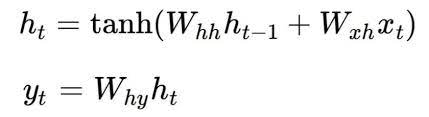
input size = mx1, hidden size = dx1   
(以單一個RNN cell計算)  
$U*X_t$, 複雜度為$O(dm)$  
$W*h_{t-1}$, 複雜度為$O(d^2)$  
**重複做n次:** 複雜度為$O(nd^2)$

`convolution: `  
注:保證input,out皆為n*d的情況下
kernal size = k*d
1. 計算一次convolution的時間複雜度為$O(kd)$
2. 在有使用padding的情況下一共必須執行n*d次convolution, 得到convolution的時間複雜度為$O(nkd^2)$

#### 序列操作數比較:  
`RNN: ` 需要操作n次,因為需要依賴上個步驟的hidden state  
`self-attention, convolution: `可以平行化處理

#### 最大路徑長度比較:
def: 距離為n的兩個節點, 傳遞信息所經歷的路徑長, 長度越長兩個結果越難交互, 信息丟失嚴重  
`RNN: `最大路徑長=n  
`self-attention: `最大路徑長=1    
`convolution: ` 
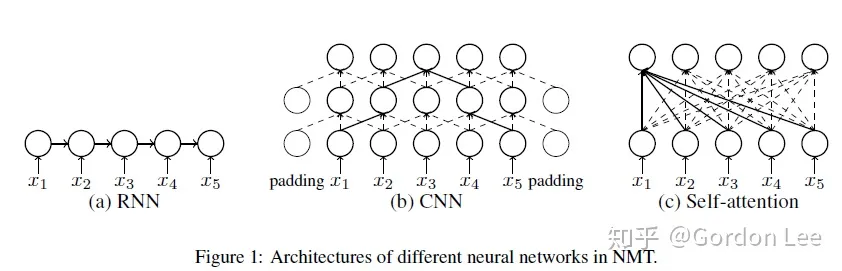
先求convolution的local context(CNN的視野) 
<center>$L*(K-1)+1$</center>  
where $L=layernum, k=kernelsize$
最大路徑其實就是L,所以max path length = $\lceil \frac{n-1}{k-1}\rceil$  
時間複雜度可以將它看作k叉樹, $leaf nodes=k^h=n$,最大路徑$h=\log_kn$, 時間複雜度為$O(\log(n))$  




# position embedding
---
self-attention不像RNN有考慮位置資訊, 但在處理序列問題中, 位置資訊仍是一個重要考慮因素, 
因此使用position embedding的方式表達位置資訊, 並透過與input seq相加的方式, 使位置資訊附加在每個token上面

Suppose that the input representation 
$\mathbf{X} \in \mathbb{R}^{n \times d}$ 
contains the $d$-dimensional embeddings 
for $n$ tokens of a sequence.
The positional encoding outputs
$\mathbf{X} + \mathbf{P}$
using a positional embedding matrix 
$\mathbf{P} \in \mathbb{R}^{n \times d}$ of the same shape,
whose element on the $i^\mathrm{th}$ row 
and the $(2j)^\mathrm{th}$
or the $(2j + 1)^\mathrm{th}$ column is

$$\begin{aligned} p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).\end{aligned}$$



In [63]:
class PositionalEncoding(nn.Module):  #@save
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        # 第0個元素開始, 步長為2取元素
        self.P[:, :, 0::2] = torch.sin(X)
        # 第1個元素開始, 步長為1取元素
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

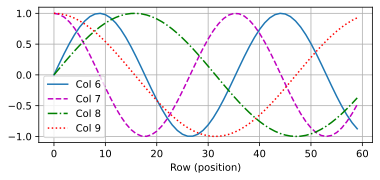

In [64]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
# X: input shape -> (1, 60, 32)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

#### Absolute Positional Information  
absolute positional information, 變化頻率是隨著維度增加嚴格遞減的, 越高維度變化頻率越小, 如下binary的sample code以及將position可視化的heatmap

In [65]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


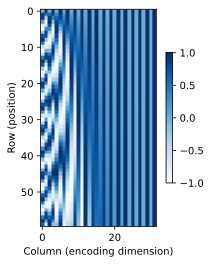

In [66]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

#### Relative Positional Information
除了 absolute position information, position embedding也可以捕捉relative position information, 
this is because
for any fixed position offset $\delta$,
the positional encoding at position $i + \delta$
can be represented by a linear projection
of that at position $i$.


This projection can be explained
mathematically.
Denoting
$\omega_j = 1/10000^{2j/d}$,
any pair of $(p_{i, 2j}, p_{i, 2j+1})$ 
can 
be linearly projected to $(p_{i+\delta, 2j}, p_{i+\delta, 2j+1})$
for any fixed offset $\delta$:

$$\begin{aligned}
&\begin{bmatrix} \cos(\delta \omega_j) & \sin(\delta \omega_j) \\  -\sin(\delta \omega_j) & \cos(\delta \omega_j) \\ \end{bmatrix}
\begin{bmatrix} p_{i, 2j} \\  p_{i, 2j+1} \\ \end{bmatrix}\\
=&\begin{bmatrix} \cos(\delta \omega_j) \sin(i \omega_j) + \sin(\delta \omega_j) \cos(i \omega_j) \\  -\sin(\delta \omega_j) \sin(i \omega_j) + \cos(\delta \omega_j) \cos(i \omega_j) \\ \end{bmatrix}\\
=&\begin{bmatrix} \sin\left((i+\delta) \omega_j\right) \\  \cos\left((i+\delta) \omega_j\right) \\ \end{bmatrix}\\
=& 
\begin{bmatrix} p_{i+\delta, 2j} \\  p_{i+\delta, 2j+1} \\ \end{bmatrix},
\end{aligned}$$

where the $2\times 2$ projection matrix does not depend on any position index $i$.


### reference
1. https://zhuanlan.zhihu.com/p/264749298
2. https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html#patch-embedding